In [1]:
!pip install ipythonblocks

#We import all the necessary libraries.
from ipythonblocks import BlockGrid
from agents import *

from search import ( # Bases for problem building
    Problem, Node, Graph, UndirectedGraph,
    SimpleProblemSolvingAgentProgram,
    GraphProblem
)

from search import ( # Uninformed search algorithms
    tree_search, graph_search, best_first_graph_search,
    breadth_first_tree_search, breadth_first_search,
    depth_first_tree_search, depth_first_graph_search,
    depth_limited_search, iterative_deepening_search,
    uniform_cost_search,
    compare_searchers
)

from search import ( # Informed search algorithms
    greedy_best_first_graph_search, astar_search
)

You should consider upgrading via the 'c:\users\carlo\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


# Environment

In [2]:
class Ball(Thing):
    pass

class Click(Thing):
    pass

#We define the environment class
class CleanupPuzzleEnvironment(Environment):
    def __init__(self, width=5, height=5):
        #We define the main characteristics of the environment. Among them, the color of the empty cells,
        #the size of the grid, and the color of the balls.
        super(CleanupPuzzleEnvironment, self).__init__()
        self.width = width
        self.height = height

        self.bg_color = (207, 216, 220)
        self.ball_color = (0, 191, 165)
        self.click_color = (244, 67, 54)
        self.grid = BlockGrid(width, height, fill=self.bg_color)

    def __str__(self):
        #We display the initial grid grid.
        world = self.get_world()
        self.draw_grid(world)
        self.grid.show()
        return ''

    def draw_grid(self, world):
        #We build the displayable grid, by showing first the grid as empty.
        #We then proceed to check all the spaces of the grid, to fill it with either clicks, balls, or leaving
        #the space empty
        self.grid[:] = self.bg_color
        for x in range(0, len(world)):
            for y in range(0, len(world[x])):
                if len(world[x][y]) and isinstance(world[x][y][0], Ball):
                    self.grid[x, y] = self.ball_color
                elif len(world[x][y]) and isinstance(world[x][y][0], Click):
                    self.grid[x, y] = self.click_color

    def get_world(self):
        #Returns the items that are in the world at the moment
        result = []
        for x in range(self.height):
            row = []
            for y in range(self.width):
                row.append(self.list_things_at((x, y)))
            result.append(row)
        return result

    def is_inbounds(self, location):
        #Checks that the location selected is inside the boundaries of the problem.
        x,y = location
        return not (x < 0 or x >= self.height or y < 0 or y >= self.width)


# Problem

In [3]:
class CleanBoardProblem(Problem):
    #We define the base problem
    def __init__(self, initial=[], goal=[], size=5):
        Problem.__init__(self, initial, goal)
        self.size = size
        self.initial_length = len(initial)

    def is_inbounds(self, location):
        #Check that the actions do not affect out of bound parts of the grid.
        x,y = location
        return not (x < 0 or x >= self.size or y < 0 or y >= self.size)

    def actions(self, state):
        #We get a list of all the actions that could be performed by the agent, and what areas of the grid it affects.
        action_coords = []

        for (x, y) in state:
            near_locations = [(x-1, y), (x+1, y), (x,y-1), (x, y+1)]
            for loc in near_locations:
                if self.is_inbounds(loc) and loc not in state and loc not in action_coords:
                    action_coords.append(loc)

        sorted_list = sorted(action_coords, key=lambda x: [x[0], x[1]])
        return tuple(sorted_list)

    def result(self, state, action):
        #We get the resulting states that could be obtained from the actions performed by the action.
        x, y = action
        near_locations = [(x-1, y), (x+1, y), (x,y-1), (x, y+1)]

        new_state = [e for e in state]
        for loc in near_locations:
            if self.is_inbounds(loc) and loc not in new_state:
                new_state.append(loc)
            elif self.is_inbounds(loc) and loc in new_state:
                new_state.remove(loc)

        sorted_list = sorted(new_state, key=lambda x: [x[0], x[1]])
        return tuple(sorted_list)

    def goal_test(self, state):
        #Check the current state to determine if we have reached the goal.
        if len(state) < 1:
            return True
        return False

    #We get the cost of each of the actions and add them together.
    def path_cost(self, c, state1, action, state2):
        return c + len(state2)
        # return c + 1

# Visualization Function

In [4]:
def display_solution(solution, initial_state, size):
    #We print the non-solution result. The case were the agent cant reach a solution.
    if not solution:
        print("Failure: no solution found")
        return

    #We print the initial state of the problem.
    print('Initial State:')
    environment = CleanupPuzzleEnvironment(size, size)
    for loc in initial_state:
        ball = Ball()
        environment.add_thing(ball, loc)
    print(environment)

    #We print all the subsequent steps, until we reach the final state.
    i = 0
    path = solution.path()
    for p in path:
        print('Step %s:' % (i+1))
        environment = CleanupPuzzleEnvironment(size, size)

        sol = solution.solution()
        if i < len(sol):
            click = Click()
            environment.add_thing(click, sol[i])

        for loc in p.state:
            ball = Ball()
            environment.add_thing(ball, loc)
        
        print(environment)
        print('')
        i += 1

# Heuristics

We present two heuristics which are described as:
<ul>
    <li><b>Heuristic one: </b></li> It's the simplest one, some kind of greedy. It only returns the value of balls in the board at every state. The assumption behind this heuristics is that the number of balls should be minimized to win the game. This heuristic is <u>Consistent</u> meaning the value of it is always lower in every node than the cost of travel from the parent to the child plus the heuristic value of the child. h(n)<=c(n,a,n')+h(n')
    <li><b>Heuristic two: </b></li> This heuristic's intention of implementation is based on how many balls would remain on the board if you click the space where the maximum number of balls can be removed. This heuristic two is our <u>Admissible one</u>, because it meets the condition where the value h(n) at every one is always lower than the perfect heuristic estimation (h*(n)) 
</ul>

In [14]:
def heuristic_one(node):
    return len(node.state)

def heuristic_two(node):
    state = node.state

    #We get a list of all the actions that could be performed by the agent, and what areas of the grid it affects.
    action_coords = []

    for (x, y) in state:
        near_locations = [(x-1, y), (x+1, y), (x,y-1), (x, y+1)]
        for loc in near_locations:
            if loc not in state and loc not in action_coords:
                action_coords.append(loc)

    sorted_list = sorted(action_coords, key=lambda x: [x[0], x[1]])

    max_balls = 0
    for (x, y) in action_coords:
        near_locations = [(x-1, y), (x+1, y), (x,y-1), (x, y+1)]
        num_balls = 0
        for loc in near_locations:
            if loc in state:
                num_balls += 1
        
        if num_balls == 4:
            max_balls = 4
            break
        
        if max_balls < num_balls:
            max_balls = num_balls

    return len(state) - max_balls


# Consistency Proof

In order to proof the Consistency of the first heuristics, we declared a basic and easy to solve 5x5 board which can be see below.

In [21]:
initial_state = tuple([(0,0), (1,1), (2,0), (3,3), (4,2), (4,4), (0,3),(1,4)])
size = 5

environment = CleanupPuzzleEnvironment(size, size)

for s in initial_state:
    ball = Ball()
    environment.add_thing(ball, s)

print(environment)

,,,,
,,,,
,,,,
,,,,
,,,,


<b>Heuristic one: </b>
The heuristic value in this initial state is 5 because is the value of removing the 3 elements at positions (3,3),(4,2),(4,4) at the lower right of the board. While the cost of travel from that initial state to the next one is 5 (because the 5 balls that would remain) and the heuristic value from the child of that node is 2 since is the number of balls remaining if it click the empty spot at position (1,0). That is 5 <= 5+2


In [22]:
initial_state = tuple([(0,0), (1,1), (2,0), (0,3),(1,4)])
size = 5

environment = CleanupPuzzleEnvironment(size, size)

for s in initial_state:
    ball = Ball()
    environment.add_thing(ball, s)

print(environment)

,,,,
,,,,
,,,,
,,,,
,,,,


Once the past step was made, the heuristic value in this state is 2 because is the number of balls at position (0,3) and (1,4). On the other hand, the real cost from this state to the next one is 2 since it is the number of remain balls, that plus the heuristic value of that state which is 0. 2 <= 2+0

Those two states always has a consistent (monotonic) value.

# Admissibility proof

To this demostration we will use the same 5x5 board.

Following the reasoning of the second heuristic, we find the click that would remove the maximum number of balls, that is (by order) the cell (4,3) which will remove 3, so the heuristic value is 5. Which is lower than 9, the real value to reach the goal from this initial state. It means 5 <= 9

In [23]:
initial_state = tuple([(0,0), (1,1), (2,0), (3,3), (4,2), (4,4), (0,3),(1,4)])
size = 5

environment = CleanupPuzzleEnvironment(size, size)

for s in initial_state:
    ball = Ball()
    environment.add_thing(ball, s)

print(environment)

,,,,
,,,,
,,,,
,,,,
,,,,


The next state, the spot that can remove most balls is (1,0) because it removes 3 then the heuristic value for this state is 5-3=2, and the real cost to move from here to the goal is 2 which meets the admissibility as well. 2 <= 2

In [25]:
initial_state = tuple([(0,0), (1,1), (2,0), (0,3),(1,4)])
size = 5

environment = CleanupPuzzleEnvironment(size, size)

for s in initial_state:
    ball = Ball()
    environment.add_thing(ball, s)

print(environment)

,,,,
,,,,
,,,,
,,,,
,,,,


# Test 1: Easy board.

For the easy test, we use the 5x5 board which we use in the proof section.
First the <b>Heuristic one</b> using the <u>A* search method</u>.

In [49]:
import time

initial_state = tuple([(0,0), (1,1), (2,0), (3,3), (4,2), (4,4), (0,3),(1,4)])

initial_state = sorted(initial_state, key=lambda x: [x[0], x[1]])
initial_state = tuple(initial_state)

size = 5

problem = CleanBoardProblem(initial_state, [], size)
start_time_A_heuristicOne = time.time()
solution_A_heuristicOne = astar_search(problem, heuristic_one)
end_time_A_heuristicOne = time.time() - start_time_A_heuristicOne

display_solution(solution_A_heuristicOne, initial_state, size)

solution_A_heuristicOne.path_cost

Initial State:


,,,,
,,,,
,,,,
,,,,
,,,,



Step 1:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 2:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 3:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 4:


,,,,
,,,,
,,,,
,,,,
,,,,


7

And then the <b>Heuristic two</b> using <u>A*</u>.

In [50]:
initial_state = tuple([(0,0), (1,1), (2,0), (3,3), (4,2), (4,4), (0,3),(1,4)])

initial_state = sorted(initial_state, key=lambda x: [x[0], x[1]])
initial_state = tuple(initial_state)

size = 5

problem = CleanBoardProblem(initial_state, [], size)
start_time_A_heuristicTwo = time.time()
solution_A_heuristicTwo = astar_search(problem, heuristic_two)
end_time_A_heuristicTwo = time.time() - start_time_A_heuristicTwo
display_solution(solution_A_heuristicTwo, initial_state, size)

solution_A_heuristicTwo.path_cost

Initial State:


,,,,
,,,,
,,,,
,,,,
,,,,



Step 1:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 2:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 3:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 4:


,,,,
,,,,
,,,,
,,,,
,,,,


7

The next two test were made using the <u>Greedy search</u> algorithm. First for the <b>Heuristic one</b>.

In [54]:
initial_state = tuple([(0,0), (1,1), (2,0), (3,3), (4,2), (4,4), (0,3),(1,4)])

initial_state = sorted(initial_state, key=lambda x: [x[0], x[1]])
initial_state = tuple(initial_state)

size = 5

problem = CleanBoardProblem(initial_state, [], size)
start_time_Greedy_heuristicOne = time.time()
solution_Greedy_heuristicOne = greedy_best_first_graph_search(problem, heuristic_one)
end_time_Greedy_heuristicOne = time.time() - start_time_Greedy_heuristicOne

display_solution(solution_Greedy_heuristicOne, initial_state, size)

solution_Greedy_heuristicOne.path_cost

Initial State:


,,,,
,,,,
,,,,
,,,,
,,,,



Step 1:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 2:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 3:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 4:


,,,,
,,,,
,,,,
,,,,
,,,,


7

And finally with the <b>Heuristic two</b>.

In [52]:
initial_state = tuple([(0,0), (1,1), (2,0), (3,3), (4,2), (4,4), (0,3),(1,4)])

initial_state = sorted(initial_state, key=lambda x: [x[0], x[1]])
initial_state = tuple(initial_state)

size = 5

problem = CleanBoardProblem(initial_state, [], size)
start_time_Greedy_heuristicTwo = time.time()
solution_Greedy_heuristicTwo = greedy_best_first_graph_search(problem, heuristic_two)
end_time_Greedy_heuristicTwo = time.time() - start_time_Greedy_heuristicTwo

display_solution(solution_Greedy_heuristicTwo, initial_state, size)
solution_Greedy_heuristicTwo.path_cost

Initial State:


,,,,
,,,,
,,,,
,,,,
,,,,



Step 1:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 2:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 3:


,,,,
,,,,
,,,,
,,,,
,,,,




Step 4:


,,,,
,,,,
,,,,
,,,,
,,,,


8

# Metrics 1

Here we show two kind of metrics, the first one is the time they took to solve the problem.

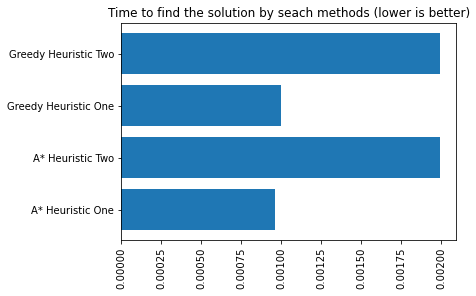

In [55]:
searchMethods = ['A* Heuristic One', 'A* Heuristic Two', 'Greedy Heuristic One', 'Greedy Heuristic Two']
timeToExecute = [end_time_A_heuristicOne,end_time_A_heuristicTwo,end_time_Greedy_heuristicOne,end_time_Greedy_heuristicTwo]

plt.barh(searchMethods,timeToExecute)
plt.xticks(rotation=90)
plt.title('Time to find the solution by seach methods (lower is better)')
plt.show()

And this second is the number of click they used to solve the problem.

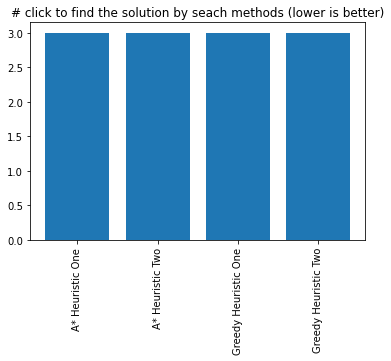

In [46]:
import matplotlib.pyplot as plt

searchMethods = ['A* Heuristic One', 'A* Heuristic Two', 'Greedy Heuristic One', 'Greedy Heuristic Two']

numberOfClicks = [
        len(solution_A_heuristicOne.solution()),
        len(solution_A_heuristicTwo.solution()),
        len(solution_Greedy_heuristicOne.solution()),
        len(solution_Greedy_heuristicTwo.solution())
    ]

plt.bar(searchMethods,numberOfClicks)
plt.xticks(rotation=90)
plt.title('# click to find the solution by seach methods (lower is better)')
plt.show()

# Test 2: Medium board.

In is going to be the board and ball's position for this medium-complexity test.

In [64]:
initial_state = tuple([(1,0), (2,1), (2,4), (3,0), (3,3), (3,5), (4,2), (4,4), (5,1), (5,3),(0,2),(1,3),(0,4)])
size = 6

environment = CleanupPuzzleEnvironment(size, size)

for s in initial_state:
    ball = Ball()
    environment.add_thing(ball, s)

print(environment)

,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,


As well as the previous test, we start with the <b>Heuristic One</b> using the <u>A* search</u> method.

In [65]:
import time

initial_state = tuple([(1,0), (2,1), (2,4), (3,0), (3,3), (3,5), (4,2), (4,4), (5,1), (5,3),(0,2),(1,3),(0,4)])

initial_state = sorted(initial_state, key=lambda x: [x[0], x[1]])
initial_state = tuple(initial_state)

size = 6

problem = CleanBoardProblem(initial_state, [], size)
start_time_A_heuristicOne = time.time()
solution_A_heuristicOne = astar_search(problem, heuristic_one)
end_time_A_heuristicOne = time.time() - start_time_A_heuristicOne

display_solution(solution_A_heuristicOne, initial_state, size)

solution_A_heuristicOne.path_cost

Initial State:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,



Step 1:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 2:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 3:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 4:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 5:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,


18

Then the <b>Heuristic Two</b> using the <u>A*</u> as well.

In [66]:
initial_state = tuple([(1,0), (2,1), (2,4), (3,0), (3,3), (3,5), (4,2), (4,4), (5,1), (5,3),(0,2),(1,3),(0,4)])

initial_state = sorted(initial_state, key=lambda x: [x[0], x[1]])
initial_state = tuple(initial_state)

size = 6

problem = CleanBoardProblem(initial_state, [], size)
start_time_A_heuristicTwo = time.time()
solution_A_heuristicTwo = astar_search(problem, heuristic_two)
end_time_A_heuristicTwo = time.time() - start_time_A_heuristicTwo
display_solution(solution_A_heuristicTwo, initial_state, size)

solution_A_heuristicTwo.path_cost

Initial State:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,



Step 1:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 2:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 3:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 4:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 5:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,


18

The <u>Greedy algorithn</u> first use the <b>Heuristic One</b>.

In [67]:
initial_state = tuple([(1,0), (2,1), (2,4), (3,0), (3,3), (3,5), (4,2), (4,4), (5,1), (5,3),(0,2),(1,3),(0,4)])

initial_state = sorted(initial_state, key=lambda x: [x[0], x[1]])
initial_state = tuple(initial_state)

size = 6

problem = CleanBoardProblem(initial_state, [], size)
start_time_Greedy_heuristicOne = time.time()
solution_Greedy_heuristicOne = greedy_best_first_graph_search(problem, heuristic_one)
end_time_Greedy_heuristicOne = time.time() - start_time_Greedy_heuristicOne

display_solution(solution_Greedy_heuristicOne, initial_state, size)

solution_Greedy_heuristicOne.path_cost

Initial State:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,



Step 1:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 2:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 3:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 4:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 5:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 6:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 7:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 8:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 9:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 10:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 11:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,


33

And finally using the <u>Greedy algorithm</u> using the <b>Heuristic Two</b>.

In [69]:
initial_state = tuple([(1,0), (2,1), (2,4), (3,0), (3,3), (3,5), (4,2), (4,4), (5,1), (5,3),(0,2),(1,3),(0,4)])

initial_state = sorted(initial_state, key=lambda x: [x[0], x[1]])
initial_state = tuple(initial_state)

size = 6

problem = CleanBoardProblem(initial_state, [], size)
start_time_Greedy_heuristicTwo = time.time()
solution_Greedy_heuristicTwo = greedy_best_first_graph_search(problem, heuristic_two)
end_time_Greedy_heuristicTwo = time.time() - start_time_Greedy_heuristicTwo

display_solution(solution_Greedy_heuristicTwo, initial_state, size)
solution_Greedy_heuristicTwo.path_cost

Initial State:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,



Step 1:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 2:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 3:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 4:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 5:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,


19

# Metrics

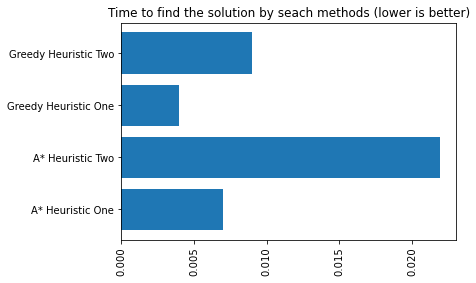

In [70]:
searchMethods = ['A* Heuristic One', 'A* Heuristic Two', 'Greedy Heuristic One', 'Greedy Heuristic Two']
timeToExecute = [end_time_A_heuristicOne,end_time_A_heuristicTwo,end_time_Greedy_heuristicOne,end_time_Greedy_heuristicTwo]

plt.barh(searchMethods,timeToExecute)
plt.xticks(rotation=90)
plt.title('Time to find the solution by seach methods (lower is better)')
plt.show()

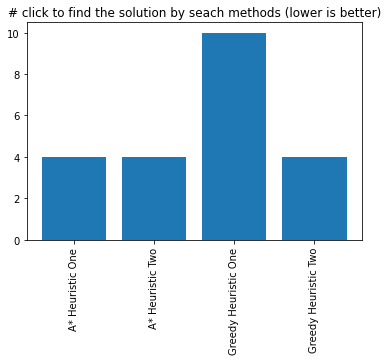

In [71]:
import matplotlib.pyplot as plt

searchMethods = ['A* Heuristic One', 'A* Heuristic Two', 'Greedy Heuristic One', 'Greedy Heuristic Two']

numberOfClicks = [
        len(solution_A_heuristicOne.solution()),
        len(solution_A_heuristicTwo.solution()),
        len(solution_Greedy_heuristicOne.solution()),
        len(solution_Greedy_heuristicTwo.solution())
    ]

plt.bar(searchMethods,numberOfClicks)
plt.xticks(rotation=90)
plt.title('# click to find the solution by seach methods (lower is better)')
plt.show()

# Test 3: Hardest problem

In [75]:
initial_state = [(0,3), (1,2), (1,4), (2,3), (3,7), (4,6), (4,3), (5,2), (5,4), (6,3), (5,9), (6,8), (6,9), (7,8), (7,10), (8,0), (8,5), (8,9), (9,1), (9,4), (9,6), (10,0), (10,5)]
size = 11

environment = CleanupPuzzleEnvironment(size, size)

for s in initial_state:
    ball = Ball()
    environment.add_thing(ball, s)

print(environment)

,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,


In [76]:
import time

initial_state = [(0,3), (1,2), (1,4), (2,3), (3,7), (4,6), (4,3), (5,2), (5,4), (6,3), (5,9), (6,8), (6,9), (7,8), (7,10), (8,0), (8,5), (8,9), (9,1), (9,4), (9,6), (10,0), (10,5)]

initial_state = sorted(initial_state, key=lambda x: [x[0], x[1]])
initial_state = tuple(initial_state)

size = 11

problem = CleanBoardProblem(initial_state, [], size)
start_time_A_heuristicOne = time.time()
solution_A_heuristicOne = astar_search(problem, heuristic_one)
end_time_A_heuristicOne = time.time() - start_time_A_heuristicOne

display_solution(solution_A_heuristicOne, initial_state, size)

solution_A_heuristicOne.path_cost

Initial State:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,



Step 1:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 2:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 3:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 4:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 5:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 6:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 7:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 8:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,


60

In [77]:
initial_state = [(0,3), (1,2), (1,4), (2,3), (3,7), (4,6), (4,3), (5,2), (5,4), (6,3), (5,9), (6,8), (6,9), (7,8), (7,10), (8,0), (8,5), (8,9), (9,1), (9,4), (9,6), (10,0), (10,5)]

initial_state = sorted(initial_state, key=lambda x: [x[0], x[1]])
initial_state = tuple(initial_state)

size = 11

problem = CleanBoardProblem(initial_state, [], size)
start_time_A_heuristicTwo = time.time()
solution_A_heuristicTwo = astar_search(problem, heuristic_two)
end_time_A_heuristicTwo = time.time() - start_time_A_heuristicTwo
display_solution(solution_A_heuristicTwo, initial_state, size)

solution_A_heuristicTwo.path_cost

Initial State:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,



Step 1:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 2:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 3:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 4:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 5:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 6:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 7:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 8:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,


60

In [78]:
initial_state = [(0,3), (1,2), (1,4), (2,3), (3,7), (4,6), (4,3), (5,2), (5,4), (6,3), (5,9), (6,8), (6,9), (7,8), (7,10), (8,0), (8,5), (8,9), (9,1), (9,4), (9,6), (10,0), (10,5)]

initial_state = sorted(initial_state, key=lambda x: [x[0], x[1]])
initial_state = tuple(initial_state)

size = 11

problem = CleanBoardProblem(initial_state, [], size)
start_time_Greedy_heuristicOne = time.time()
solution_Greedy_heuristicOne = greedy_best_first_graph_search(problem, heuristic_one)
end_time_Greedy_heuristicOne = time.time() - start_time_Greedy_heuristicOne

display_solution(solution_Greedy_heuristicOne, initial_state, size)

solution_Greedy_heuristicOne.path_cost

Initial State:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,



Step 1:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 2:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 3:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 4:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 5:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 6:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 7:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 8:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 9:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 10:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 11:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 12:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 13:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 14:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 15:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 16:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,


86

In [79]:
initial_state = [(0,3), (1,2), (1,4), (2,3), (3,7), (4,6), (4,3), (5,2), (5,4), (6,3), (5,9), (6,8), (6,9), (7,8), (7,10), (8,0), (8,5), (8,9), (9,1), (9,4), (9,6), (10,0), (10,5)]

initial_state = sorted(initial_state, key=lambda x: [x[0], x[1]])
initial_state = tuple(initial_state)

size = 11

problem = CleanBoardProblem(initial_state, [], size)
start_time_Greedy_heuristicTwo = time.time()
solution_Greedy_heuristicTwo = greedy_best_first_graph_search(problem, heuristic_two)
end_time_Greedy_heuristicTwo = time.time() - start_time_Greedy_heuristicTwo

display_solution(solution_Greedy_heuristicTwo, initial_state, size)
solution_Greedy_heuristicTwo.path_cost

Initial State:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,



Step 1:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 2:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 3:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 4:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 5:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 6:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 7:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,




Step 8:


,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,
,,,,,,,,,,


61

# Metrics

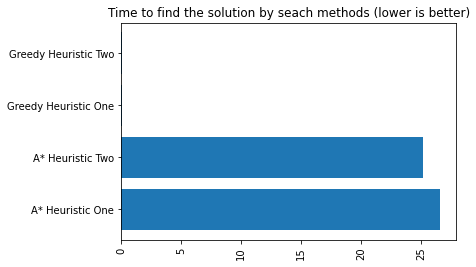

In [80]:
searchMethods = ['A* Heuristic One', 'A* Heuristic Two', 'Greedy Heuristic One', 'Greedy Heuristic Two']
timeToExecute = [end_time_A_heuristicOne,end_time_A_heuristicTwo,end_time_Greedy_heuristicOne,end_time_Greedy_heuristicTwo]

plt.barh(searchMethods,timeToExecute)
plt.xticks(rotation=90)
plt.title('Time to find the solution by seach methods (lower is better)')
plt.show()

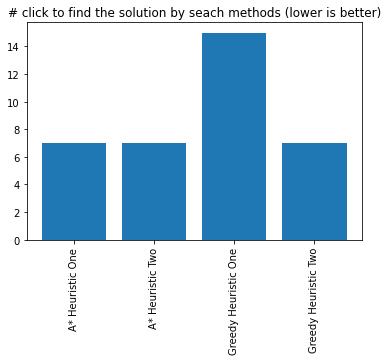

In [81]:
import matplotlib.pyplot as plt

searchMethods = ['A* Heuristic One', 'A* Heuristic Two', 'Greedy Heuristic One', 'Greedy Heuristic Two']

numberOfClicks = [
        len(solution_A_heuristicOne.solution()),
        len(solution_A_heuristicTwo.solution()),
        len(solution_Greedy_heuristicOne.solution()),
        len(solution_Greedy_heuristicTwo.solution())
    ]

plt.bar(searchMethods,numberOfClicks)
plt.xticks(rotation=90)
plt.title('# click to find the solution by seach methods (lower is better)')
plt.show()

# ESTA PARTE SE PUEDE BORRAR

In [58]:
initial_state = tuple([(0,0), (1,1), (2,0), (3,3), (4,2), (4,4)])
initial_state = tuple([(1,0), (2,1), (2,4), (3,0), (3,3), (3,5), (4,2), (4,4), (5,1), (5,3)])
# initial_state = tuple([(0,3), (1,2), (1,4), (2,3), (3,7), (4,6), (4,3), (5,2), (5,4), (6,3), (5,9), (6,8), (6,9), (7,8), (7,10), (8,0), (8,5), (8,9), (9,1), (9,4), (9,6), (10,0), (10,5)])
size = 6

environment = CleanupPuzzleEnvironment(size, size)

for s in initial_state:
    ball = Ball()
    environment.add_thing(ball, s)

print(environment)

,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,


In [10]:
# initial_state = [(0,0), (1,1), (2,0), (4,3), (3,2), (3,4), (1,2), (0,3), (1,4)]
initial_state = [(1,0), (2,1), (2,4), (3,0), (3,3), (3,5), (4,2), (4,4), (5,1), (5,3)]
# initial_state = [(0,3), (1,2), (1,4), (2,3), (3,7), (4,6), (4,3), (5,2), (5,4), (6,3), (5,9), (6,8), (6,9), (7,8), (7,10), (8,0), (8,5), (8,9), (9,1), (9,4), (9,6), (10,0), (10,5)]

initial_state = sorted(initial_state, key=lambda x: [x[0], x[1]])
initial_state = tuple(initial_state)

size = 6

problem = CleanBoardProblem(initial_state, [], size)
solution = astar_search(problem, heuristic_one)

display_solution(solution, initial_state, size)

solution.path_cost

Initial State:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,



Step 1:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 2:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 3:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 4:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,


9

In [12]:
# initial_state = [(0,0), (1,1), (2,0), (4,3), (3,2), (3,4), (1,2), (0,3), (1,4)]
initial_state = [(1,0), (2,1), (2,4), (3,0), (3,3), (3,5), (4,2), (4,4), (5,1), (5,3)]
# initial_state = [(0,3), (1,2), (1,4), (2,3), (3,7), (4,6), (4,3), (5,2), (5,4), (6,3), (5,9), (6,8), (6,9), (7,8), (7,10), (8,0), (8,5), (8,9), (9,1), (9,4), (9,6), (10,0), (10,5)]

initial_state = sorted(initial_state, key=lambda x: [x[0], x[1]])
initial_state = tuple(initial_state)

size = 6

problem = CleanBoardProblem(initial_state, [], size)
solution = greedy_best_first_graph_search(problem, heuristic_one)

display_solution(solution, initial_state, size)

solution.path_cost

Initial State:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,



Step 1:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 2:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 3:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 4:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 5:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 6:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 7:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 8:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 9:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,




Step 10:


,,,,,
,,,,,
,,,,,
,,,,,
,,,,,
,,,,,


24